We'll be trying to predict hause price with regression models.

Let's get started!

# Import libraries

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns 



# Checking the datasets

In [3]:
train_df = pd.read_csv("C:/Users/angel/Desktop/Machine Learning Angela/house-prices-advanced-regression-techniques/train.csv")
test_df = pd.read_csv("C:/Users/angel/Desktop/Machine Learning Angela/house-prices-advanced-regression-techniques/test.csv")

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
Id               1459 non-null int64
MSSubClass       1459 non-null int64
MSZoning         1455 non-null object
LotFrontage      1232 non-null float64
LotArea          1459 non-null int64
Street           1459 non-null object
Alley            107 non-null object
LotShape         1459 non-null object
LandContour      1459 non-null object
Utilities        1457 non-null object
LotConfig        1459 non-null object
LandSlope        1459 non-null object
Neighborhood     1459 non-null object
Condition1       1459 non-null object
Condition2       1459 non-null object
BldgType         1459 non-null object
HouseStyle       1459 non-null object
OverallQual      1459 non-null int64
OverallCond      1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
RoofStyle        1459 non-null object
RoofMatl         1459 non-null object
Exterior1st      1458 non-

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603


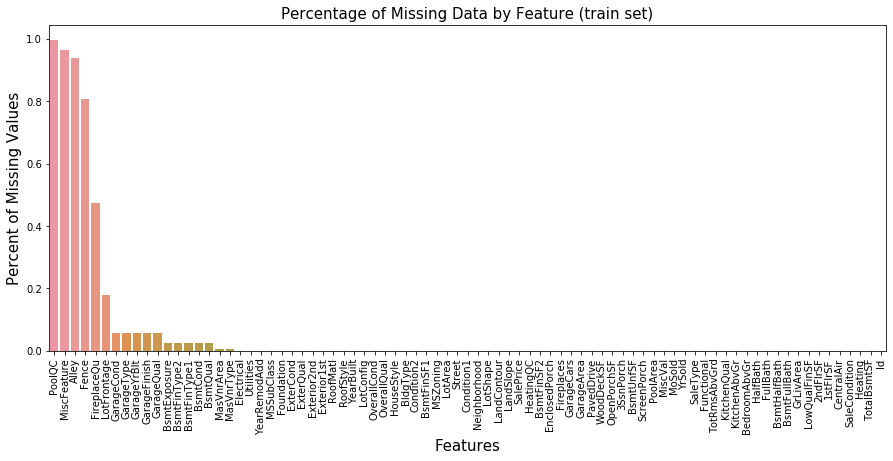

In [6]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of Missing Values', fontsize=15)
plt.title('Percentage of Missing Data by Feature (train set)', fontsize=15)
missing_data.head()

,Total,Percent
PoolQC,1456,0.997944
MiscFeature,1408,0.965045
Alley,1352,0.926662
Fence,1169,0.801234
FireplaceQu,730,0.500343


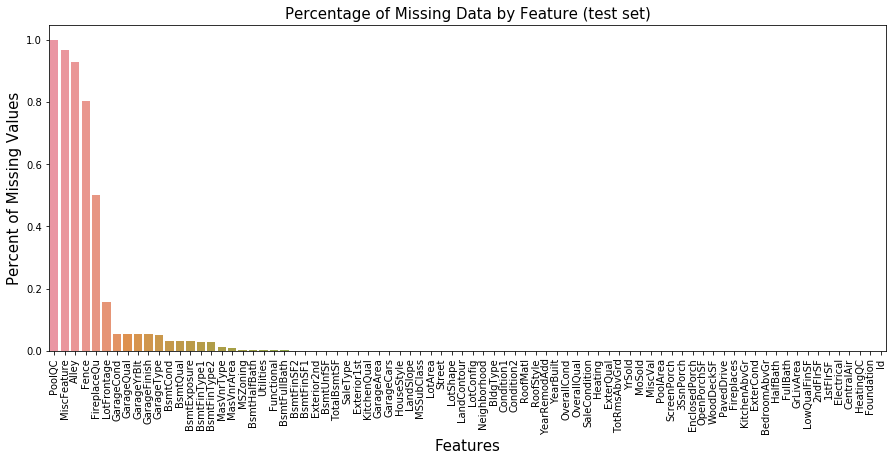

In [7]:
total = test_df.isnull().sum().sort_values(ascending=False)
percent = (test_df.isnull().sum()/test_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of Missing Values', fontsize=15)
plt.title('Percentage of Missing Data by Feature (test set)', fontsize=15)
missing_data.head()

The very first problem is that we have 80 features for prediction. And we have to pick only the important ones.

The second question we must figure out are what to do with lots of missing values.

And finally, we must turn all the 'sting' objects to numeric values.

## Pre-analysis.
First, lets check the SalePrice column to clearly understand the distibution of prices.

In [8]:
train_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Mean price is around 180k USD, the most expensive house is for 775k USD and the cheapest is only for 34,9k USD. 50 quantile lies at 163k USD.

Draw a distribution plot of prices.

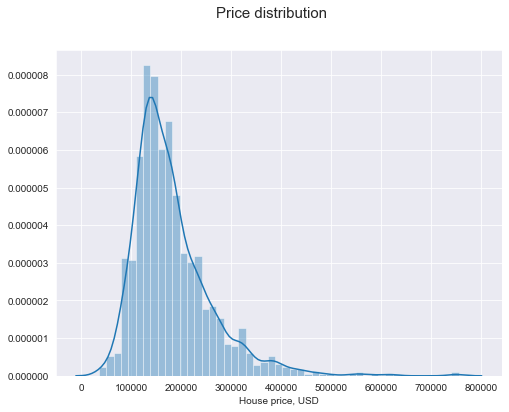

In [9]:
sns.set_style('darkgrid')

fig,ax = plt.subplots(1,1,figsize=(8,6))
sns.distplot(train_df['SalePrice'], ax=ax)

ax.set_xlabel('House price, USD')
plt.suptitle('Price distribution', size=15)
plt.show()


Correlation matrix

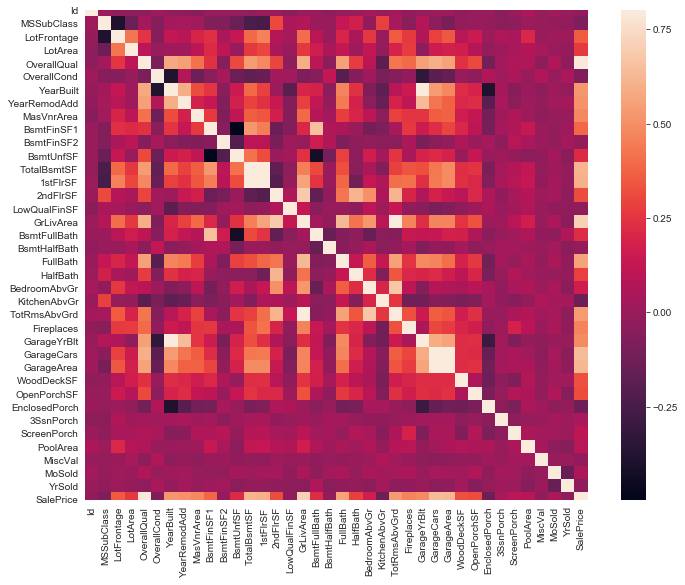

In [10]:
corrmat = train_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

In my opinion, this heat map is the best way to get a quick overview of the relationships between our features.

Let's analyze the correlation between features and the target variable.

In [20]:
train_df.corr()['SalePrice'].sort_values(ascending=False).head(15)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
Name: SalePrice, dtype: float64

In [21]:
# more correlated features
features_correlated = ['SalePrice','OverallQual','GrLivArea',
                       'GarageCars','GarageArea','TotalBsmtSF',
                       '1stFlrSF','FullBath','TotRmsAbvGrd',
                       'YearBuilt','YearRemodAdd']

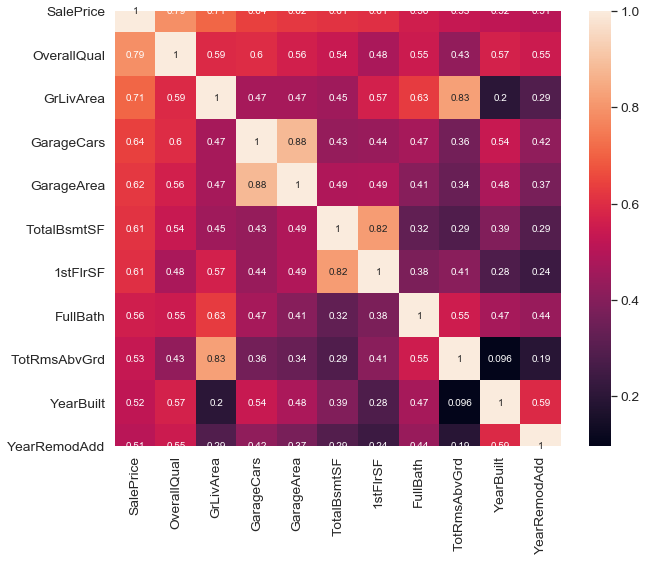

In [28]:
correlated = train_df[features_correlated].corr()
axis = plt.subplots(figsize = (10,8))
sns.heatmap(correlated, annot=True, annot_kws = {"size":10})